# Walmart Sales Forecasting using Time-Series Analysis

<b>One of the most crucial elements of strategic planning is predicting future sales for a company.</b>

In this kernal, I have analyzed in depth how internal and external factors of one of the biggest grocery chain WALMART can affect their Weekly Sales in future.

This module contains analysis of data, including time series analysis, recognizes the best performing stores, perform predictions on sales with help of linear regression models.

The data collected consists of sales data ranging from 2010 to 2012 for the 45 Walmart stores across US. Some external feature points like CPI, Unemployment rate and Fuel prices in the region of the store helped me to make a more detailed analysis.

## Introduction

<b>Supply Chain Management</b> is one of the biggest issues faced by Retail industry. The main focus is to balance the supply and demand in a manner that achieve the financial and service objectives of the enterprise.

If the store authorities get to know the demand of products that are sold in the store, it will be helpful for them to plan the supply chain accordingly. 


## Data

The analysis is performed on 3 datasets:
1. <b>Store</b>: The data consists of store numbers ranging from 1 to 45.

2. <b>Type</b>: The data consists of three types of stores 'A', 'B' and 'C'.

3. <b>Size</b>: The data consists of the size of the store which is mainly determined by the number of products sold in the store.

## Sales Data

Various features in the dataset are as follows:
1. <b>Date</b>: The date of the week when the observations were noted
2. <b>Weekly_Sales</b>: The sales recorded that week
3. <b>Store</b>: The store number where the observation was recorded
4. <b>Dept</b>: A number from 1 to 99 that shows the department number
5. <b>IsHoliday</b>: A boolean value representing a holiday week or not
6. <b>Temperature</b>: The temperature of the region during the week
7. <b>Fuel_Price</b>: The fuel price in that region during the week
8. <b>MarkDown1:5</b>: It represents the type of markdown and the quantity of the product available that week
9. <b>CPI</b>: Customer Price Index during that week
10. <b>Unemployment</b>: The unemployment rate during that week in the region of the store


## Models used:

1. Lasso Regressor
2. Random Forest Regressor
3. Gradient Boosting Regressor
4. Support Vector Regressor
5. Time Series Analysis

------------------------------------------------------------------------------------------

### Part 1: Data Preprocessing

In [459]:
# Importing the required modules for the data analysis

import warnings
import itertools
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from datetime import timedelta

In [460]:
# Initializing the Standard Scaling technique to scale the data

ss = StandardScaler()

In [461]:
# Reading the datasets using pandas and creating a dataframe

walmart = pd.read_csv('train.csv')

walmart_feature = pd.read_csv('features.csv')

walmart_store = pd.read_csv('stores.csv')

In [462]:
# Grouping the data to avoid the departmental sales and getting the cummulative sales

walmart_store_group = walmart.groupby(['Store', 'Date'])[['Weekly_Sales']].sum()

walmart_store_group.reset_index(inplace=True)

In [463]:
# Merging all the datasets for easy testing and analysis

result = pd.merge(walmart_store_group,
                  walmart_store, 
                  how='inner', 
                  on='Store', 
                  left_on=None, 
                  right_on=None,
                  left_index=False,
                  right_index=False,
                  sort=False,
                  suffixes=('_x', '_y'),
                  copy=True,
                  indicator=False)


data = pd.merge(result,
                walmart_feature,
                how='inner',
                on=['Store', 'Date'],
                left_on=None,
                right_on=None,
                left_index=False,
                right_index=False,
                sort=False,
                suffixes=('_x', '_y'),
                copy=True,
                indicator=False)



In [464]:
# Displaying the result dataset

result

,Store,Date,Weekly_Sales,Type,Size
0,1,2010-02-05,1643690.90,A,151315
1,1,2010-02-12,1641957.44,A,151315
2,1,2010-02-19,1611968.17,A,151315
3,1,2010-02-26,1409727.59,A,151315
4,1,2010-03-05,1554806.68,A,151315
...,...,...,...,...,...
6430,45,2012-09-28,713173.95,B,118221
6431,45,2012-10-05,733455.07,B,118221
6432,45,2012-10-12,734464.36,B,118221
6433,45,2012-10-19,718125.53,B,118221


In [465]:
# Getting the information of result dataset

result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Type          6435 non-null   object 
 4   Size          6435 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 301.6+ KB


In [466]:
# Displaying the data sataset

data

,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
6431,45,2012-10-05,733455.07,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False
6432,45,2012-10-12,734464.36,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False
6433,45,2012-10-19,718125.53,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False


In [467]:
# Getting the information of data dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Type          6435 non-null   object 
 4   Size          6435 non-null   int64  
 5   Temperature   6435 non-null   float64
 6   Fuel_Price    6435 non-null   float64
 7   MarkDown1     2280 non-null   float64
 8   MarkDown2     1637 non-null   float64
 9   MarkDown3     2046 non-null   float64
 10  MarkDown4     1965 non-null   float64
 11  MarkDown5     2295 non-null   float64
 12  CPI           6435 non-null   float64
 13  Unemployment  6435 non-null   float64
 14  IsHoliday     6435 non-null   bool   
dtypes: bool(1), float64(10), int64(2), object(2)
memory usage: 760.4+ KB


### Part 2: Data Cleaning

In [468]:
# Encoding the categorical column 'IsHoliday' with 1 and 0

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x== True else 0)

In [469]:
# Converting the Date column type to date time pandas

data['Date'] = pd.to_datetime(data.Date)

# Extracting Day, Month and Year from the data
data['Day'] = data.Date.dt.day
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year

# Changing the Months value from numbers to real values
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])




In [470]:
# Checking for the null values

data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

In [471]:
# Getting the description of the dataset

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Size,6435.0,1.302876e+05,63117.022465,34875.000,70713.000,126512.000000,2.023070e+05,2.196220e+05
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
MarkDown1,2280.0,6.855587e+03,8183.310015,0.270,1679.190,4972.590000,8.873583e+03,8.864676e+04
MarkDown2,1637.0,3.218966e+03,9268.082387,-265.760,37.200,187.040000,1.785290e+03,1.045195e+05
MarkDown3,2046.0,1.349853e+03,9287.242800,-29.100,4.700,22.700000,9.998750e+01,1.416306e+05
MarkDown4,1965.0,3.303858e+03,6211.203947,0.220,483.270,1419.420000,3.496080e+03,6.747485e+04
MarkDown5,2295.0,4.435262e+03,5868.933325,135.160,1702.565,3186.520000,5.422080e+03,1.085193e+05


In [472]:
# Creating a week column in the dataset for further analysis for weeksly sales

data['Week'] = data.Date.dt.isocalendar().week

### Part 3: Exploratory Data Analysis

In [473]:
# Exploring the descriptors of the dataset

data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Store,6435.000000,23.000000,12.988182,1.000000,12.000000,23.000000,34.000000,45.000000
Weekly_Sales,6435.000000,1046964.877562,564366.622054,209986.250000,553350.105000,960746.040000,1420158.660000,3818686.450000
Size,6435.000000,130287.600000,63117.022465,34875.000000,70713.000000,126512.000000,202307.000000,219622.000000
Temperature,6435.000000,60.663782,18.444933,-2.060000,47.460000,62.670000,74.940000,100.140000
Fuel_Price,6435.000000,3.358607,0.459020,2.472000,2.933000,3.445000,3.735000,4.468000
MarkDown1,2280.000000,6855.587430,8183.310015,0.270000,1679.190000,4972.590000,8873.582500,88646.760000
MarkDown2,1637.000000,3218.965504,9268.082387,-265.760000,37.200000,187.040000,1785.290000,104519.540000
MarkDown3,2046.000000,1349.853021,9287.242800,-29.100000,4.700000,22.700000,99.987500,141630.610000
MarkDown4,1965.000000,3303.858142,6211.203947,0.220000,483.270000,1419.420000,3496.080000,67474.850000
MarkDown5,2295.000000,4435.262240,5868.933325,135.160000,1702.565000,3186.520000,5422.080000,108519.280000


In [474]:
# Plotting a graph for sales over weeks

df_weeks = data.groupby('Week').sum()

import plotly.express as px
fig = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, title = 'Sales over weeks')
fig.update_traces(line_color='deeppink', line_width=3)


In [475]:
# Comparing the sales with Markdowns by plotting graphs

import plotly.graph_objs as go
from plotly import tools

fig = go.Figure()

fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )

fig.update_layout(title = 'Sales vs Markdown', xaxis_title = 'Weeks')

In [476]:
# Temporarily filling the missing markdown values with -500

data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

In [477]:
# Creating a function to plot the graphs

def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

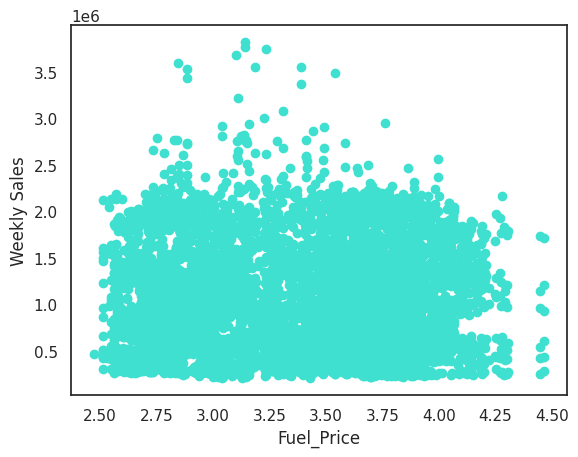

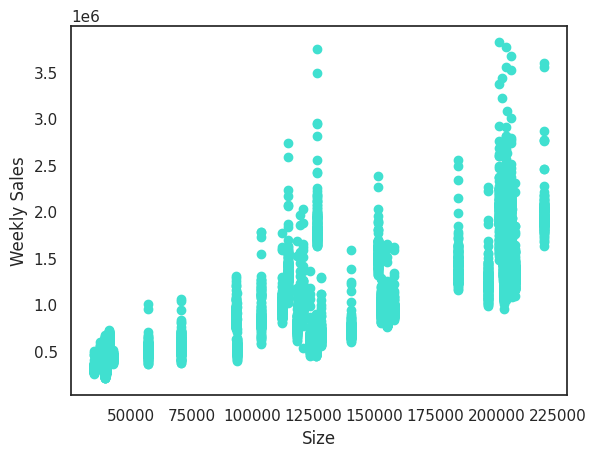

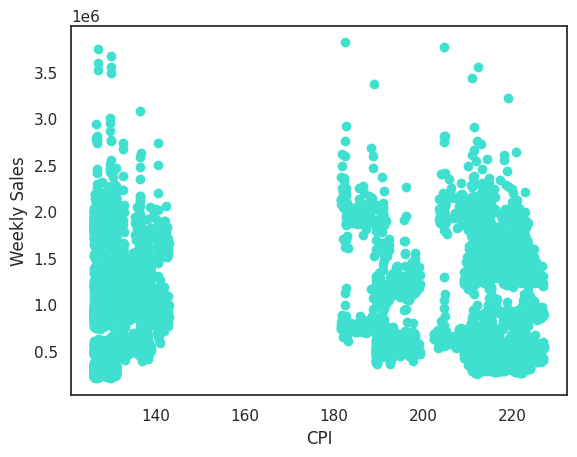

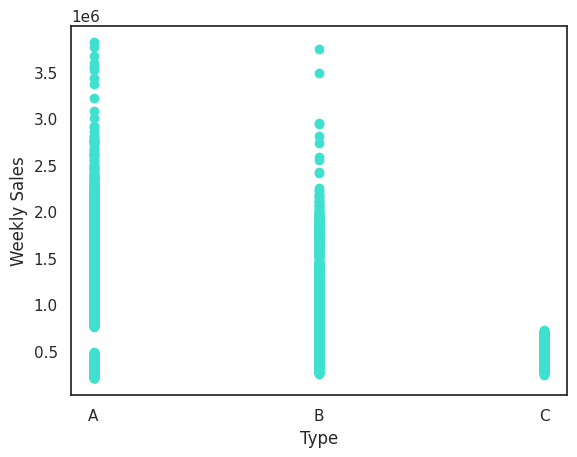

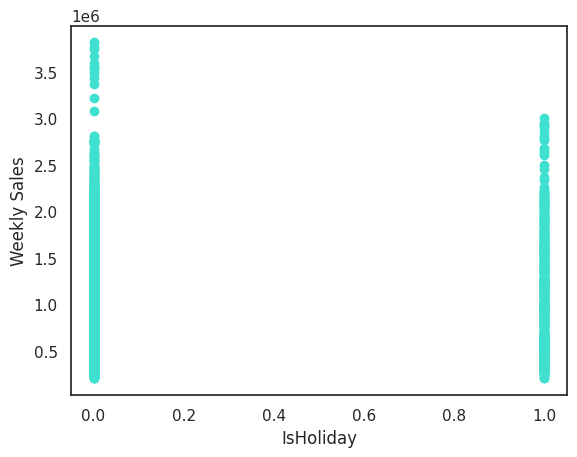

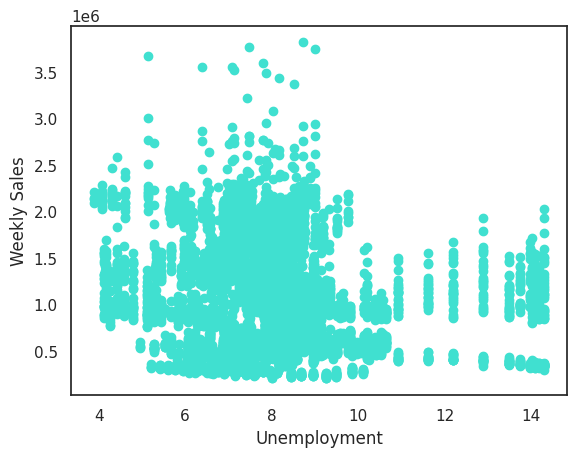

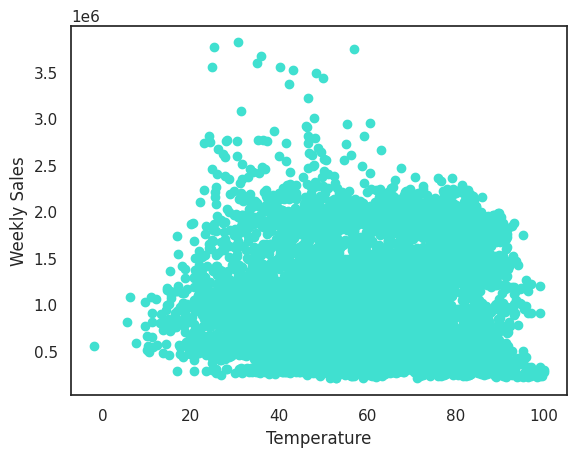

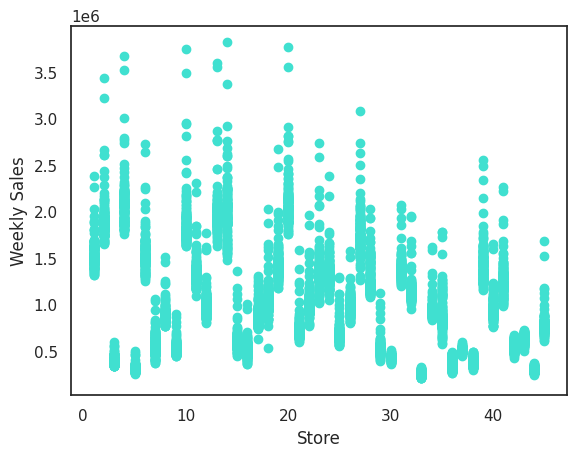

In [478]:
# Plotting the graphs for all columns

scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')

In [479]:
# Creating a week column

data['Week'] = data.Date.dt.isocalendar().week 


In [480]:
# Viewing the first 5 rows of the dataset

data.head()


,Store,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Day,Month,Year,Week
0,1,2010-02-05,1643690.90,A,151315,42.31,2.572,-500.0,-500.0,-500.0,-500.0,-500.0,211.096358,8.106,0,5,Feb,2010,5
1,1,2010-02-12,1641957.44,A,151315,38.51,2.548,-500.0,-500.0,-500.0,-500.0,-500.0,211.242170,8.106,1,12,Feb,2010,6
2,1,2010-02-19,1611968.17,A,151315,39.93,2.514,-500.0,-500.0,-500.0,-500.0,-500.0,211.289143,8.106,0,19,Feb,2010,7
3,1,2010-02-26,1409727.59,A,151315,46.63,2.561,-500.0,-500.0,-500.0,-500.0,-500.0,211.319643,8.106,0,26,Feb,2010,8
4,1,2010-03-05,1554806.68,A,151315,46.50,2.625,-500.0,-500.0,-500.0,-500.0,-500.0,211.350143,8.106,0,5,Mar,2010,9


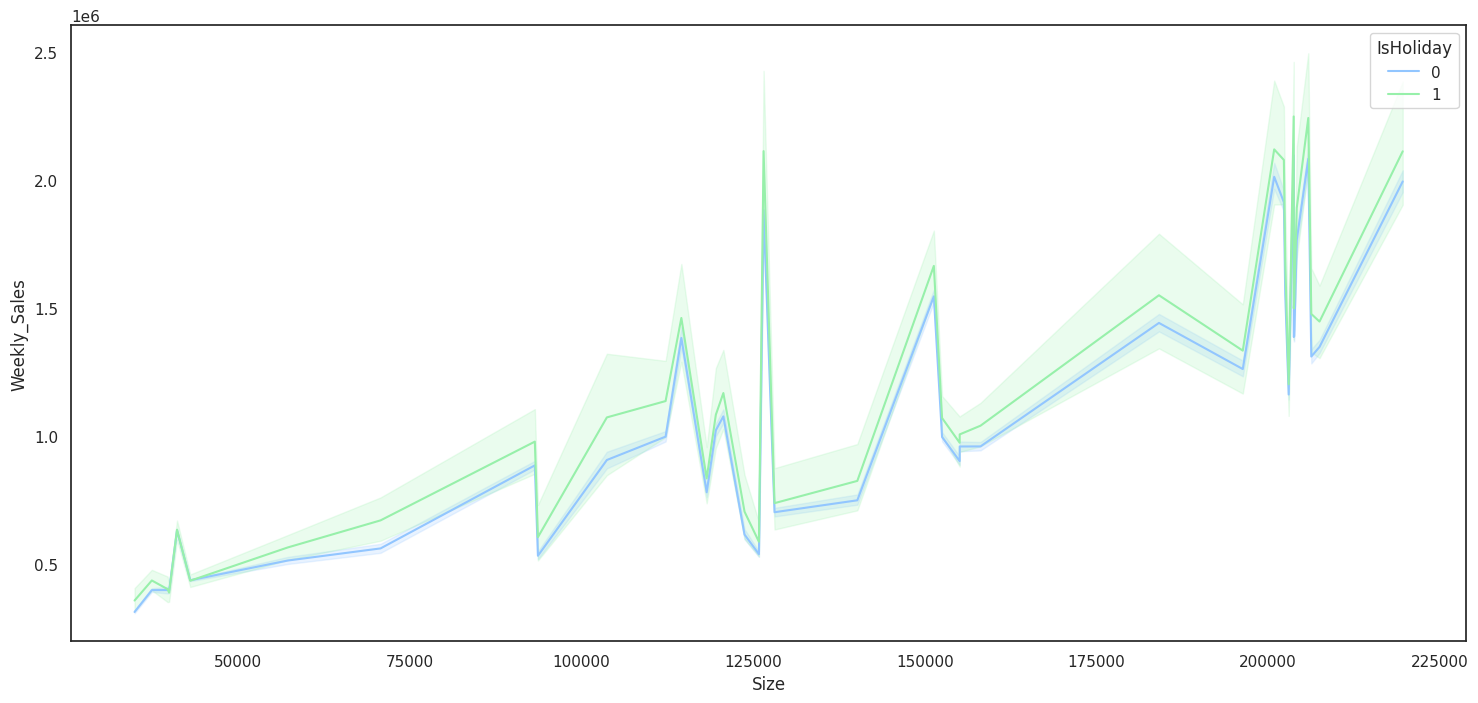

In [481]:
# Checking the relationship of Weekly_Sales with the Size of the store

plt.figure(figsize=(18,8))
sns.lineplot ( data = data, x = 'Size', y =  'Weekly_Sales', hue = 'IsHoliday');

In [482]:
# Plotting a histogram to get the relation between Weekly_Sales and Temperature

px.histogram(data, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [483]:
# Plotting a histogram to get the relation between Weekly_Sales and Fuel_Price

px.histogram(data, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [484]:
# Plotting the histogram to get the relation between CPI and Weekly_Sales

px.histogram(data, x='CPI', y ='Weekly_Sales', color='IsHoliday')


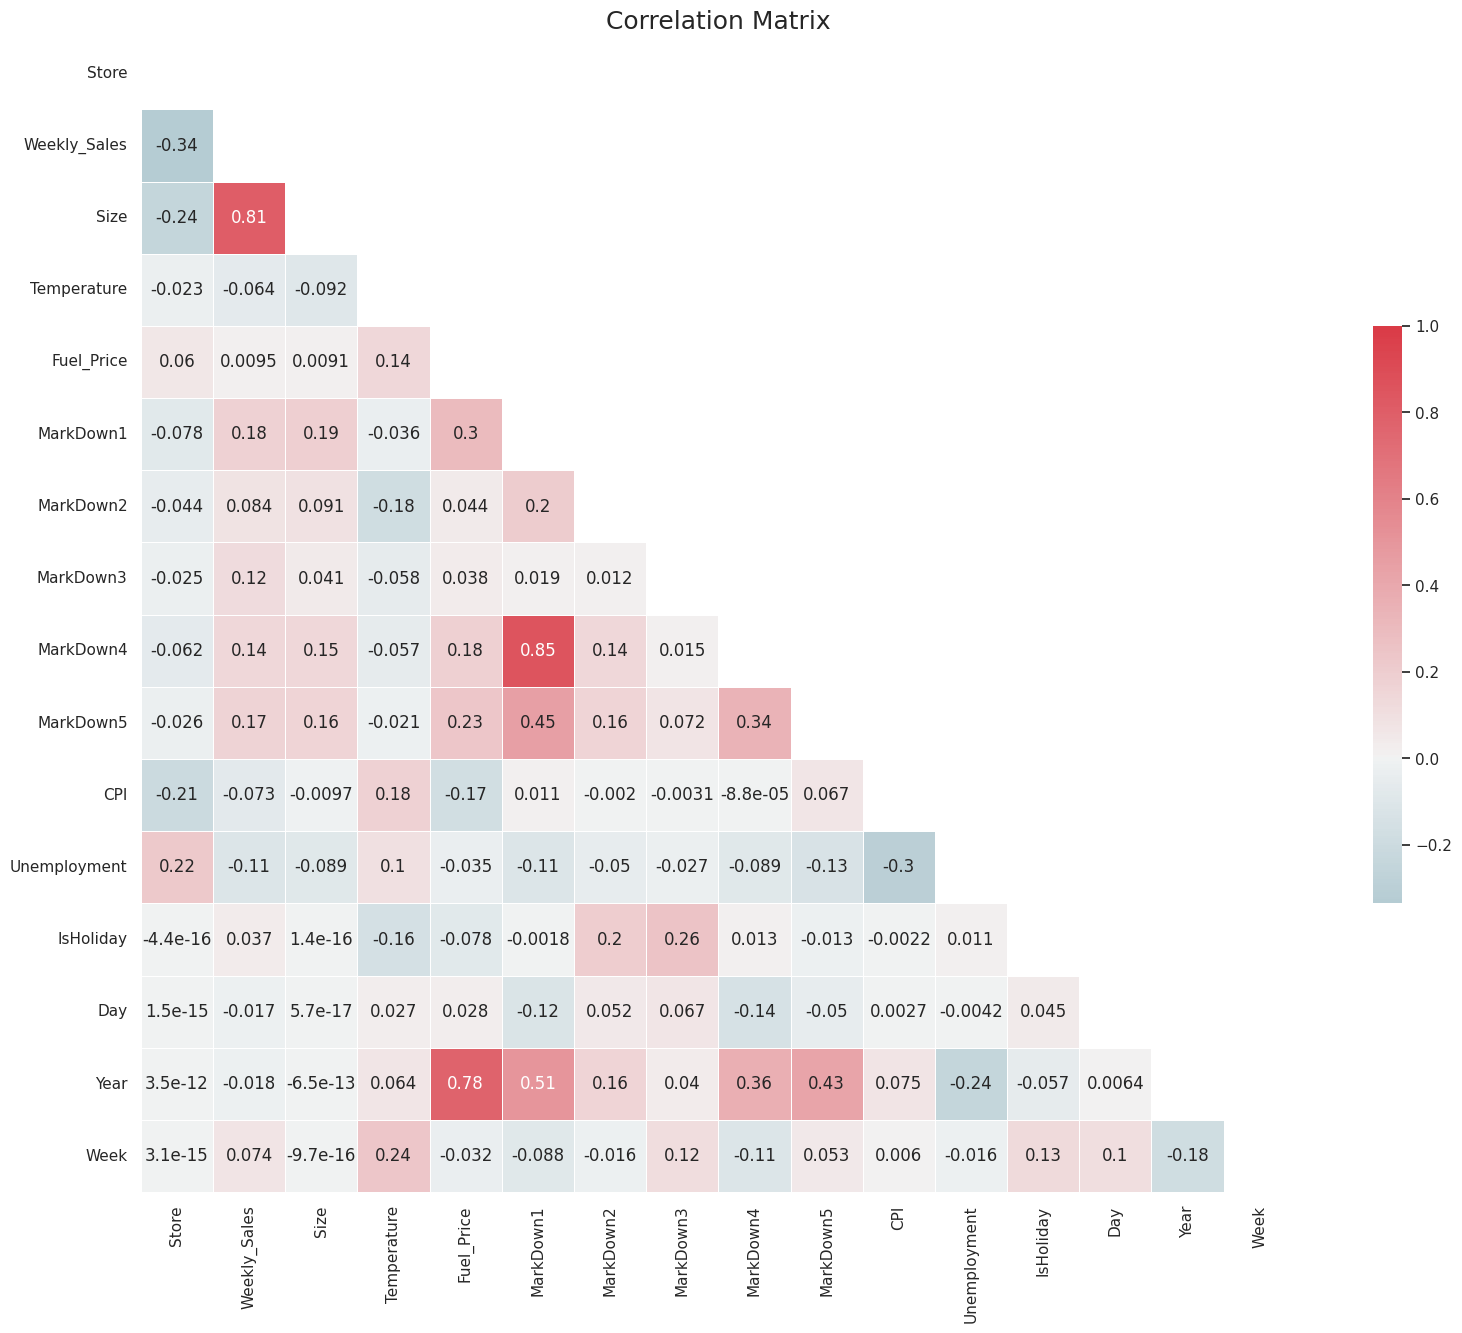

In [485]:
# Creating a correlation matrix

sns.set(style="white")

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Part 4: Detailed Time Series Analysis

In [486]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are 45 different stores in this dataset. We will perform analysis of store 4

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store number 4

sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])

sales4.set_index('Date',inplace = True)

In [487]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store number 6

sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
sales6.set_index('Date',inplace = True)

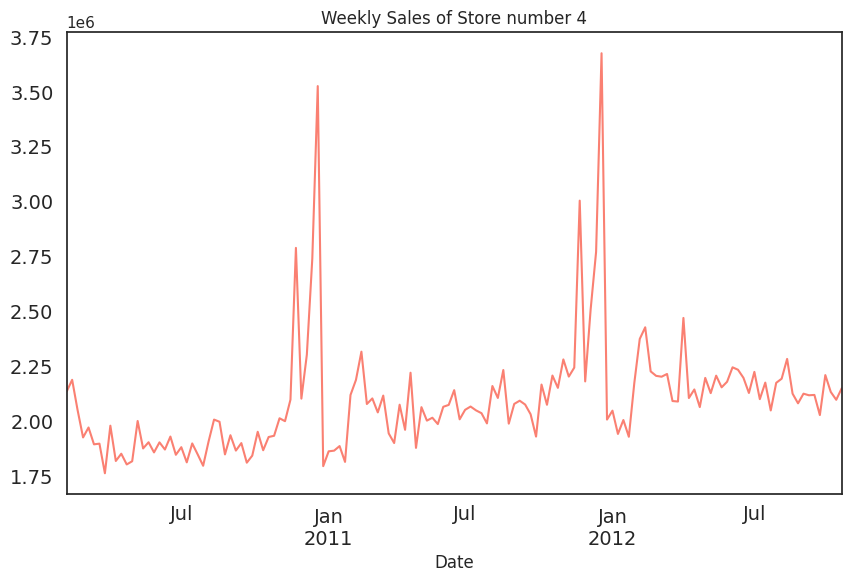

In [488]:
# Plotting the weekly sales of store 4

sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store number 4', fontsize=14, color = 'salmon')
plt.show()

The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). The seasonal_decompose() function returns a result object which contains arrays to access four pieces of data from the decomposition.

<Figure size 640x480 with 0 Axes>

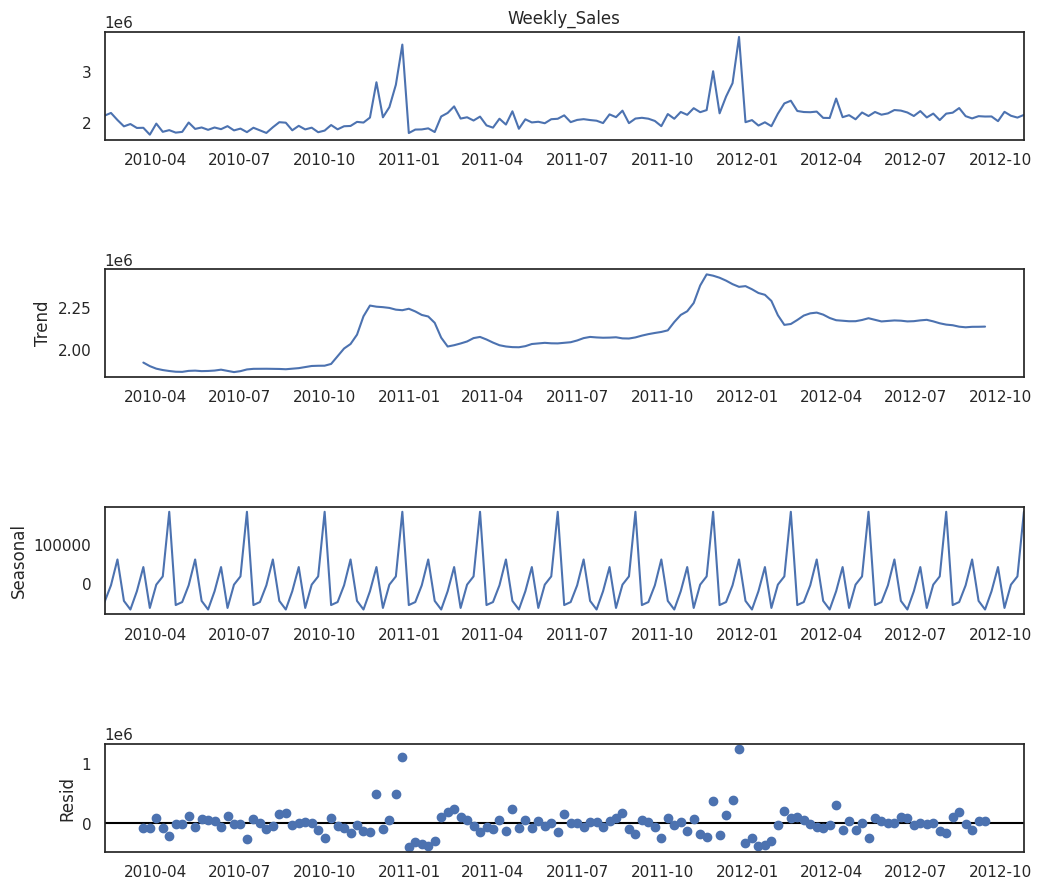

In [489]:
# Importing the seasonal decompose function
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting a graph for weekly sales trends
decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [490]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

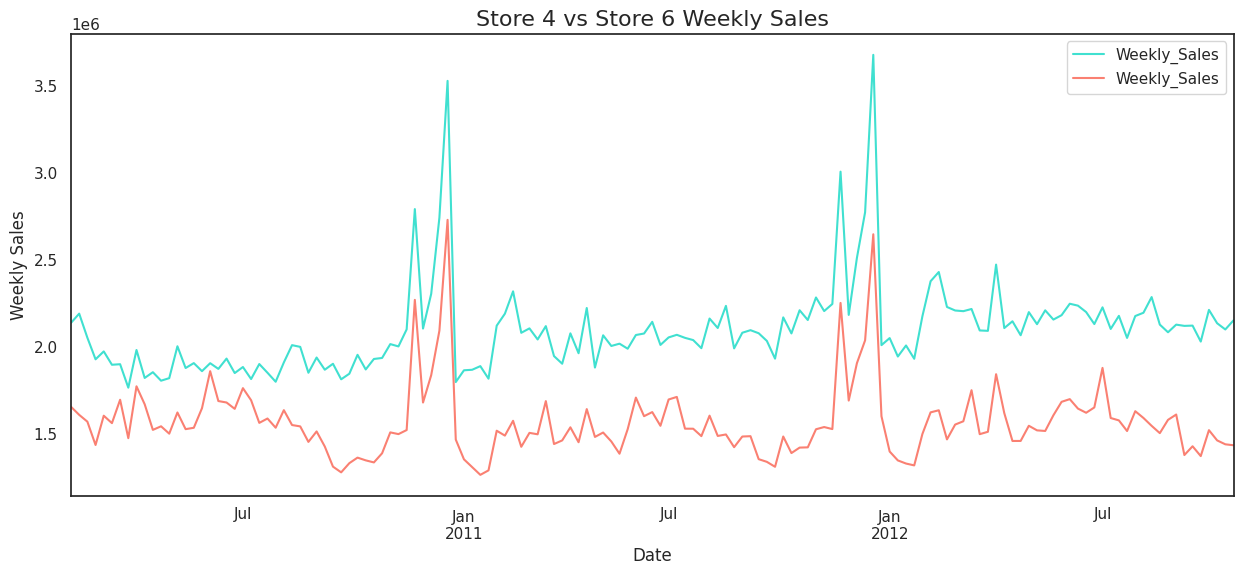

In [491]:
# Comparing the weekly sales of both the stores by plotting a graph

y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store 4 vs Store 6 Weekly Sales', fontsize = '16')
plt.show()

In [492]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [493]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32190D+00    |proj g|=  2.11788D-01

At iterate    5    f=  8.19196D+00    |proj g|=  3.64631D-01

At iterate   10    f=  8.03865D+00    |proj g|=  1.09207D+00

At iterate   15    f=  7.98422D+00    |proj g|=  3.19891D-01

At iterate   20    f=  7.98333D+00    |proj g|=  9.54173D-02

At iterate   25    f=  7.98300D+00    |proj g|=  5.21600D-02

At iterate   30    f=  7.98248D+00    |proj g|=  2.89649D-01

At iterate   35    f=  7.98218D+00    |proj g|=  1.98280D-02

At iterate   40    f=  7.98216D+00    |proj g|=  2.99676D-02

At iterate   45    f=  7.98210D+00    |proj g|=  2.08806D-02

At iterate   50    f=  7.98208D+00    |proj g|=  8.83194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

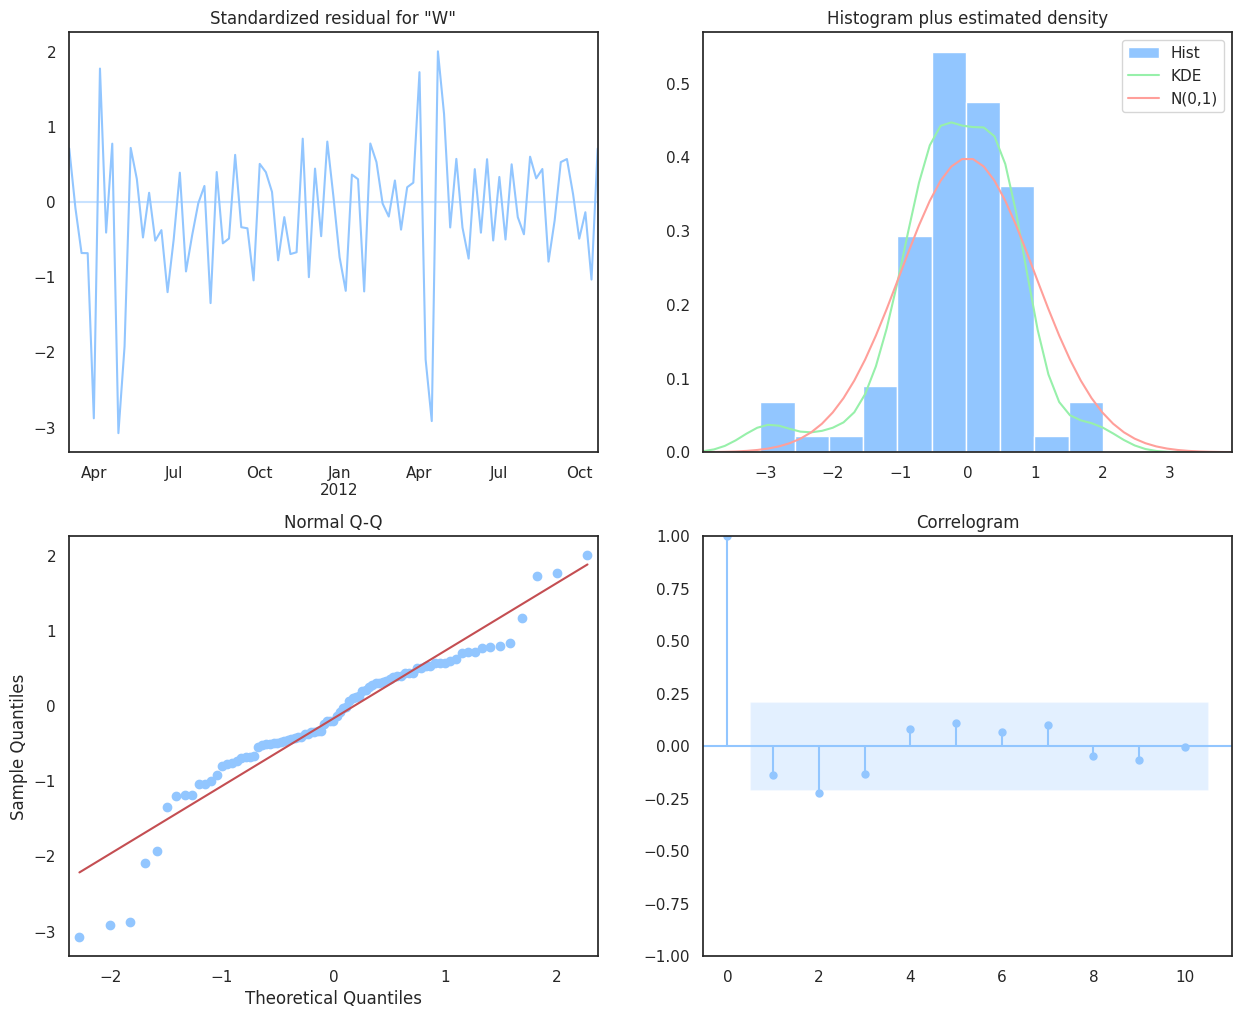

In [494]:
# Plotting the graphs for comparison

plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [495]:
# I am going to predict for the last 90 days. 
# Fixing the sub-dataset

pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

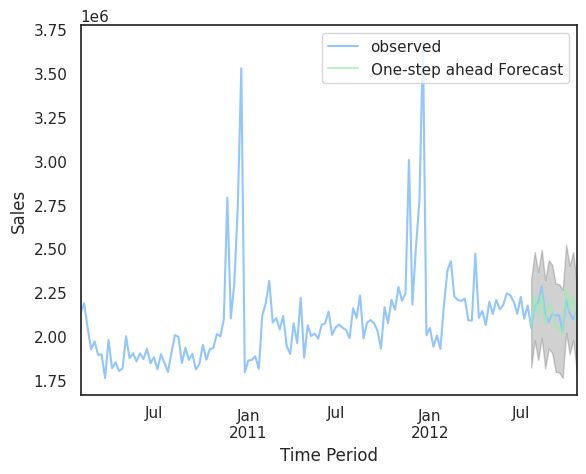

In [496]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [497]:
# Getting a sub-dataset

y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Computing the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4720670036.79


In [498]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

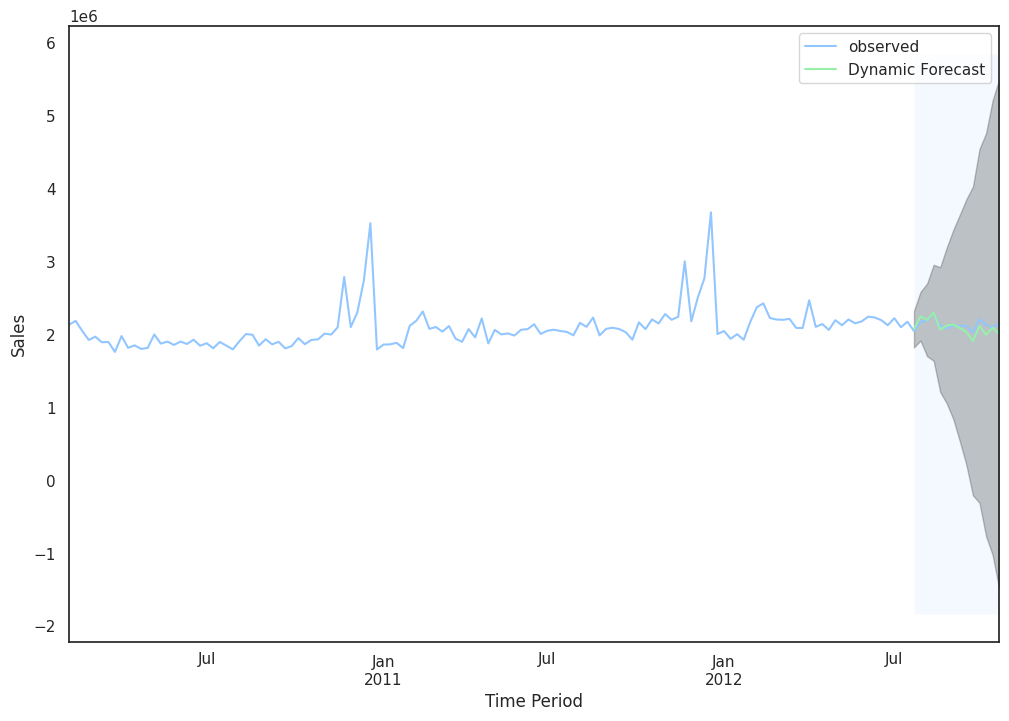

In [499]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

The graph above show the observed and predicted values going together indicating nearly accurate prediction

In [500]:
# Extracting the predicted true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Computing the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 75447.73


In [501]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 836786.2419193671


In [502]:

# Predicting the forecast of 12 weeks ahead
pred_uc = results.get_forecast(steps=12)

# Getting confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

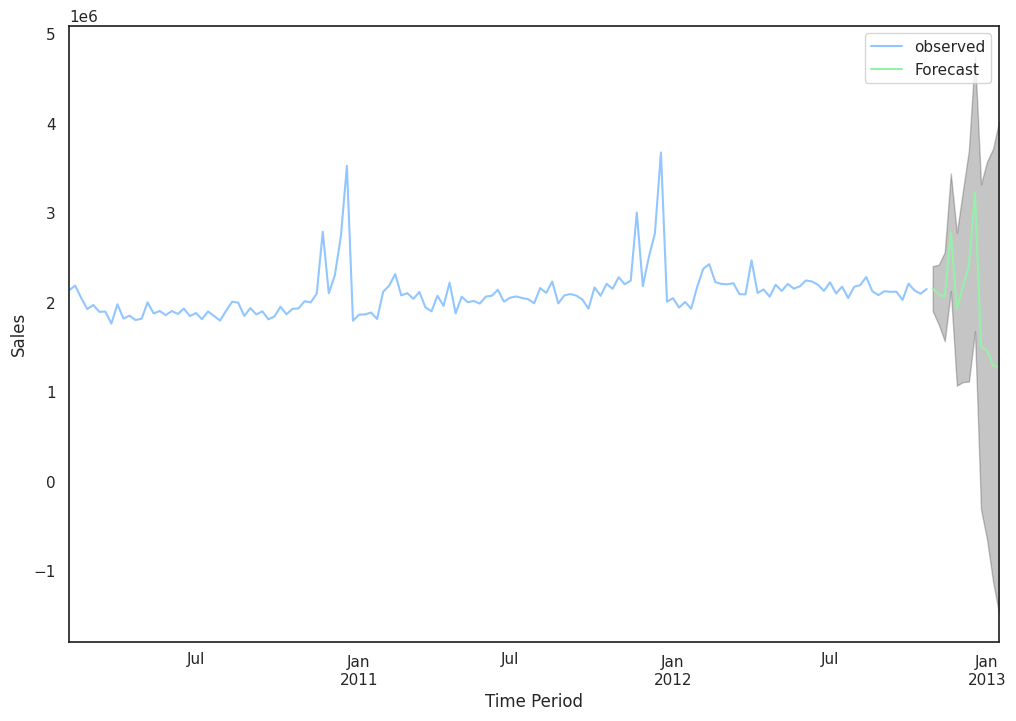

In [503]:

# Plotting the graphs for predicted and observed values
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

The error interval is coming out to be high for future predictions.

### Part 5: Modelling and Machine Learning

In [504]:
# create dummy variables for 'Type' 
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

 

In [505]:
# Creating a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    fig, ax = plt.subplots(figsize=(12,8))

    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()

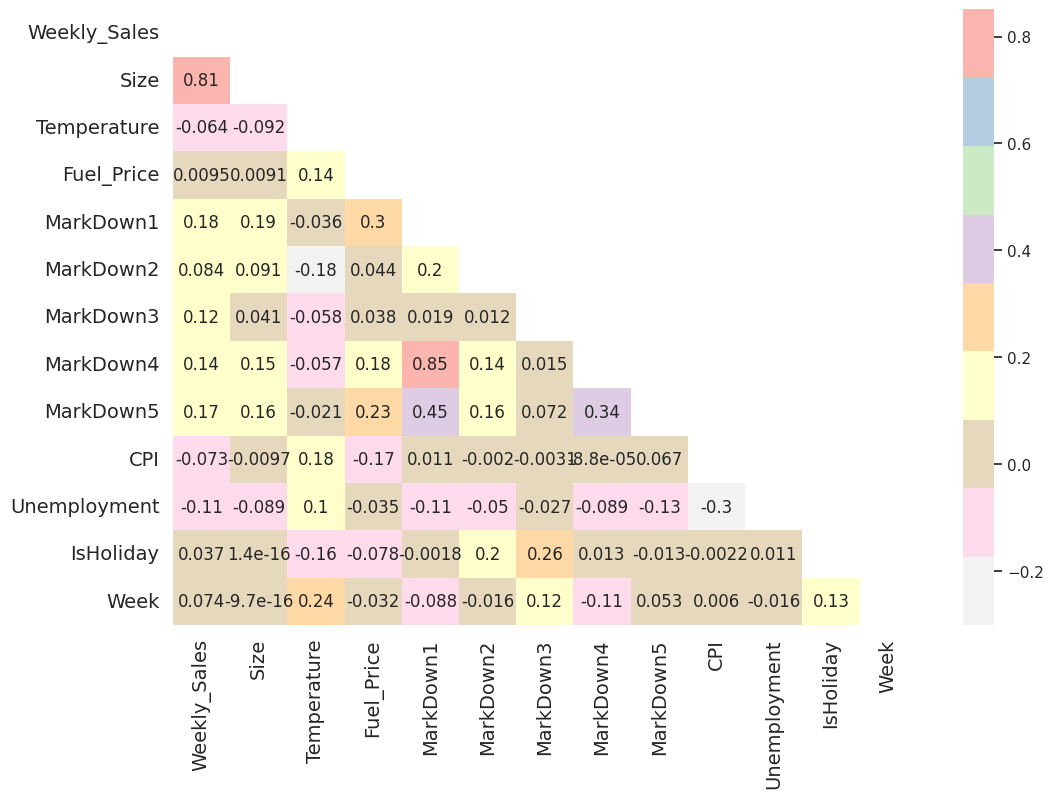

In [506]:
# Plotting the correlation matrix
correlation_heat_map(data_heatmap_df)


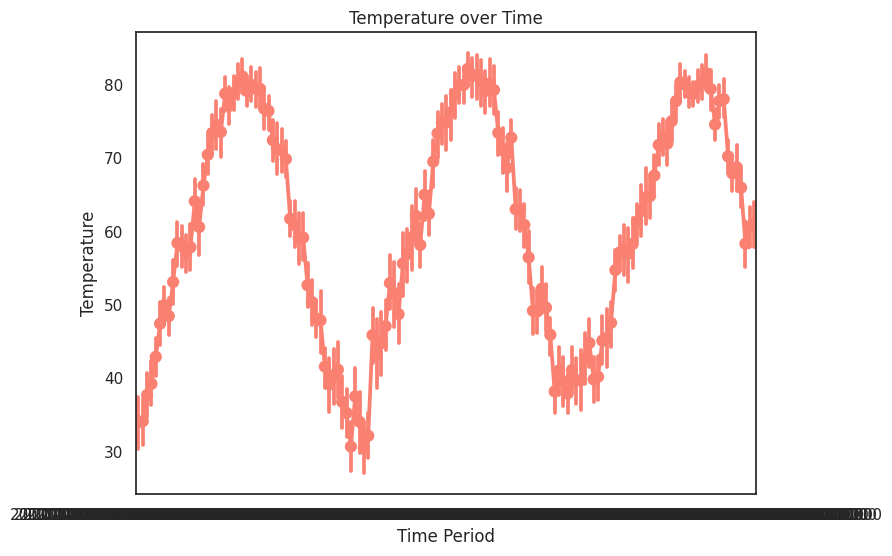

In [507]:
# Plotitng the data for temperature change with time
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()

Inferrence from above graph: Temperature is more of a seasonal and repeated in cycles

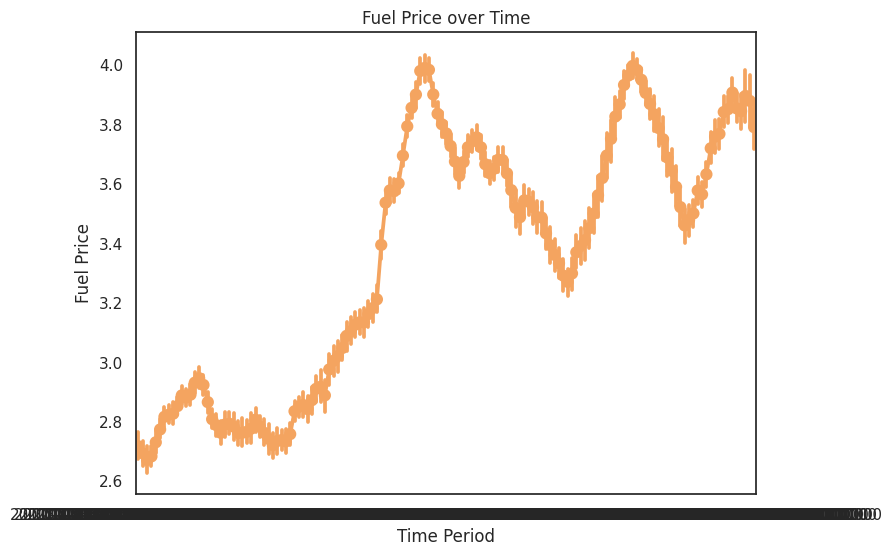

In [508]:
# Plotting the graph for fuel prices changeing over time
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()

Inferrence from above graph: The Fuel Price varies over time and consists of high and low values

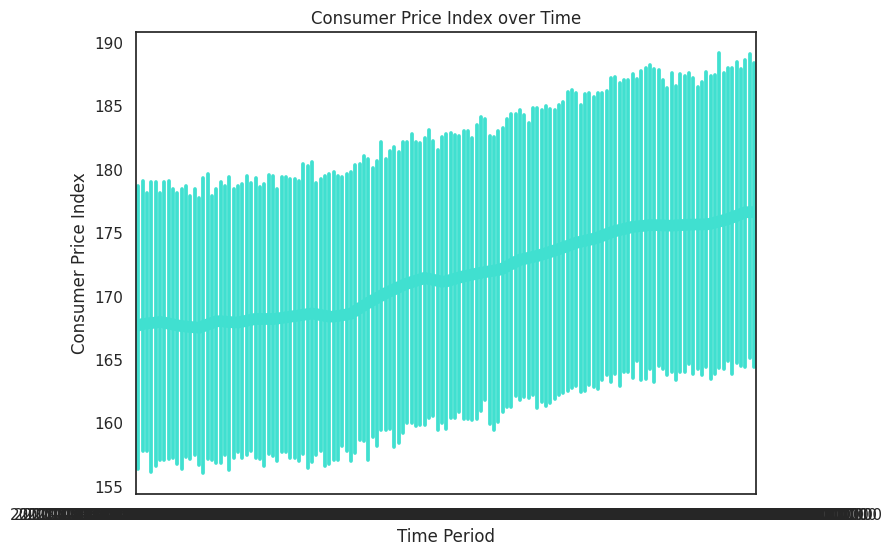

In [509]:
# Plotting the graph for CPI values changing over time
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()

Inferrence from above graph: CPI has increased over time

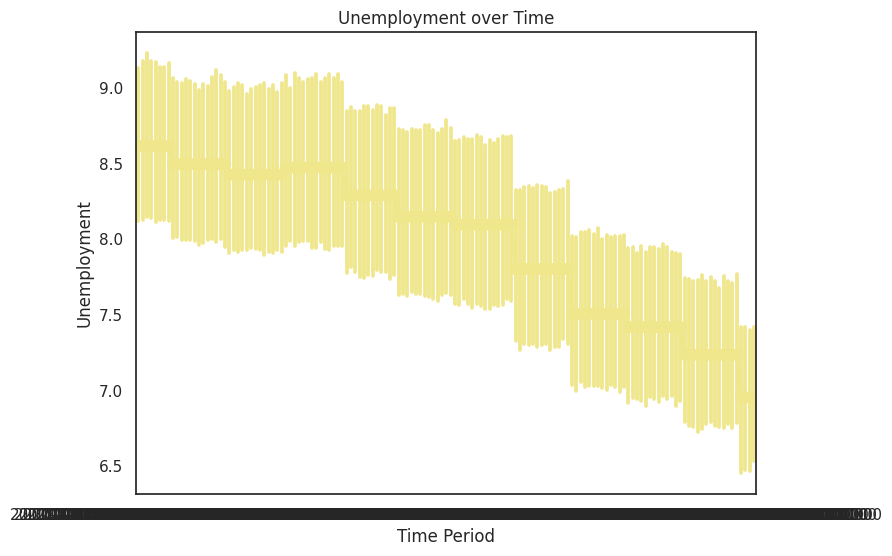

In [510]:
# Plotting the graph for unemployment rates chaning over time
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()

Inferrence from above graph: Unemployment has decreased over time. 

##### Virtual Analysis

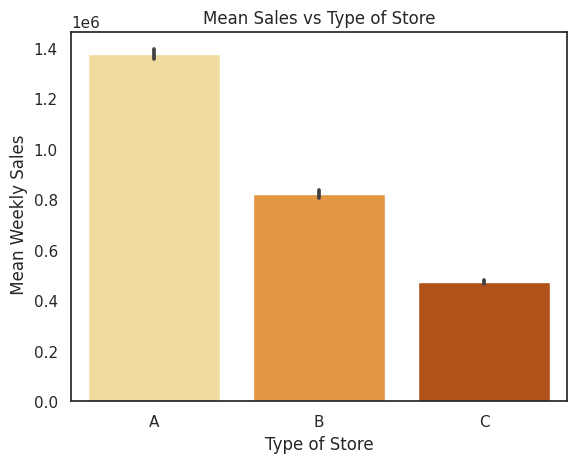

In [511]:
# Comparing the type of store and sales
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
#plt.savefig('./images/Type_vs_Sales.png')
plt.show()

Inferrence from above graph: Type A > Type B > Type C in weekly sales

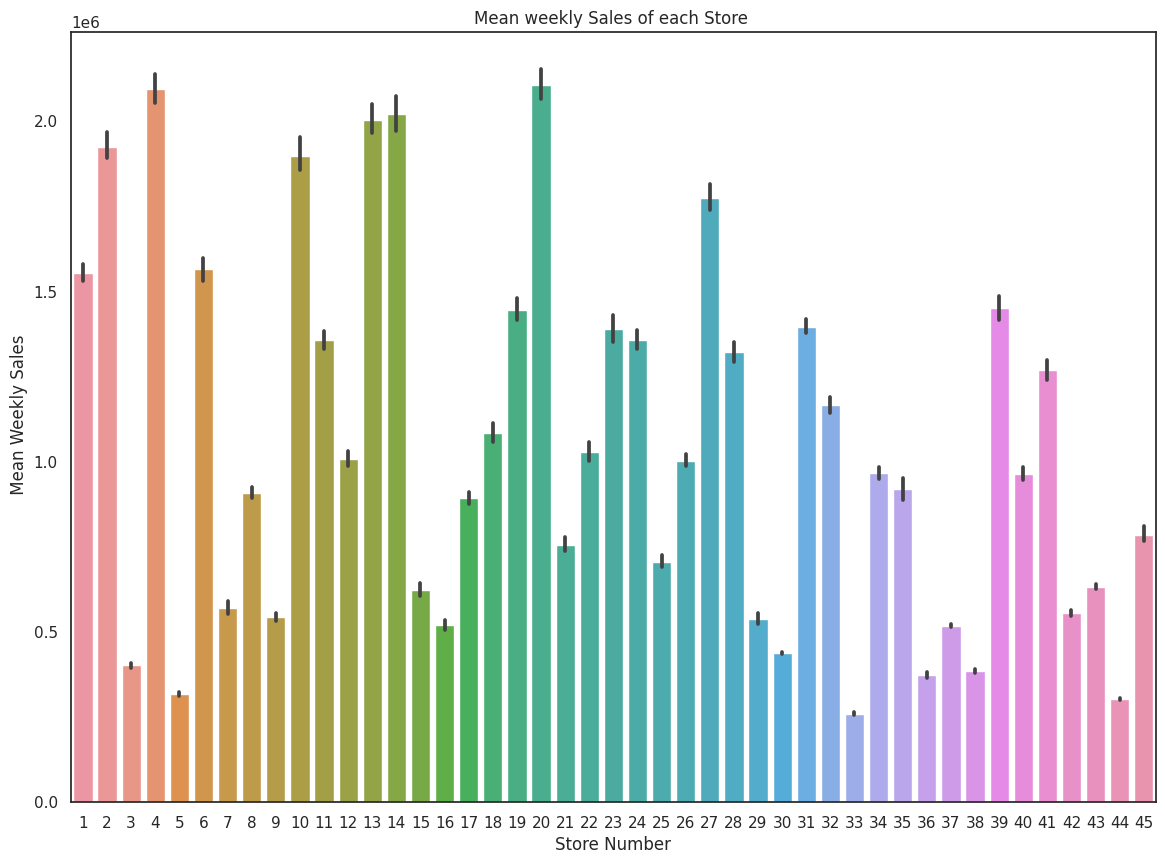

In [512]:
# Plotting weekly sales for all the stores
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

Inferrence from above graph: The weekly sales among all stores range from $250,000 to $2,200,000.

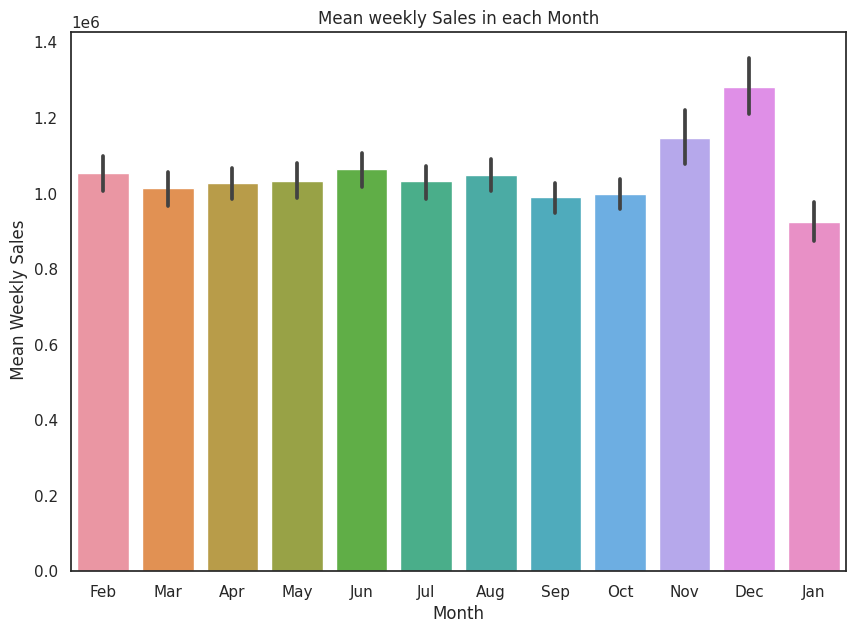

In [513]:
# Plotting weekly sales according to month
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()

Inferrence from above graph: December experiences high sales and January has the least sales

### Feature Engineering

In [514]:
# Creating dummies for "Store, Month and Year" columns

# Creating a column for the week
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [515]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [516]:
# Dropping the columns for which dummies are generated
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

In [517]:
# Dropping the column from the list of dummies 
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 

In [518]:
data.iloc[:,5:10].describe().T


,count,mean,std,min,25%,50%,75%,max
MarkDown1,6435.0,2106.175500,6008.334618,-500.0,-500.0,-500.0,2302.300,88646.76
MarkDown2,6435.0,446.067837,4946.234382,-500.0,-500.0,-500.0,0.090,104519.54
MarkDown3,6435.0,88.158396,5306.320800,-500.0,-500.0,-500.0,3.705,141630.61
MarkDown4,6435.0,661.551088,3853.055534,-500.0,-500.0,-500.0,314.320,67474.85
MarkDown5,6435.0,1260.128491,4227.342723,-500.0,-500.0,-500.0,1983.265,108519.28


As seen from the results above, the Markdown columns have a lot of outliers present. More than 50% of the data is missing.

In [519]:
# Dropping the markdown columns

data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [520]:
missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales. 

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()

In [521]:
# Creating a function to determine the best k for regressor models
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [522]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

##### KNN Regressor

In [523]:
# Training the KNN Regressor
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute



Best R2 value: 0.14140639091506765 
Best k:  25


In [524]:
# KNN Regressor after scaling the data for Markdown column 2

impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

Best R2 value: 0.41503402148479146 
Best k:  25


In [525]:
# KNN Regressor after scaling the data for Markdown column 3

impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute

Best R2 value: 0.20431863554303203 
Best k:  25


In [526]:
# KNN Regressor after scaling the data for Markdown column 4

impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

Best R2 value: 0.3470822603116795 
Best k:  25


In [527]:
# KNN Regressor after scaling the data for Markdown column 5

impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

Best R2 value: 0.0815206539204145 
Best k:  25


The accuracy and R2 scores are not good for the Markdown columns. 

I replaced the missing values in Markdown columns with KNN imputation. Analysis will be done with both data values

In [528]:
walmart_data=data_imputed.copy()


##### Modelling with Linear Regression

0.9438065170367517
0.9443815804827265
Adjusted R^2 0.9431526934928397
Cross-validated scores: [0.93906888 0.94176606 0.93335128 0.94109137 0.92967877 0.96002338
 0.92691588 0.95012734 0.95639217 0.94532654]
Mean Cross validation 0.9423741673993586


Text(0.5, 1.0, 'Predicted vs Actual Sales')

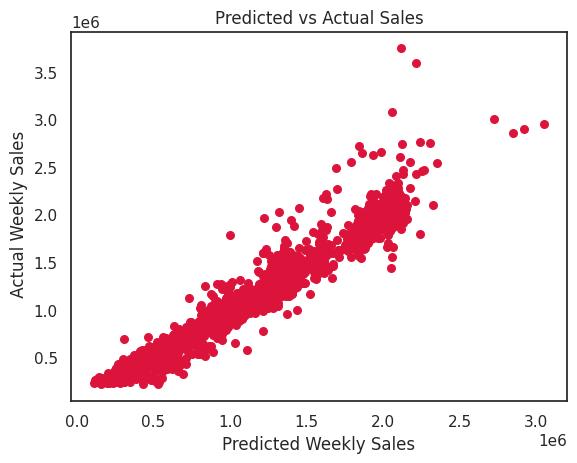

In [529]:
# Modelling with Linear Regression with imputed Markdowns

predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

0.9306750837510844
0.9426427198179688
Cross-validated scores: [ 7.00623668e-01 -1.33870520e+14 -6.84387285e+13 -1.72280102e+13
 -1.23415215e+13 -4.95210879e+13 -4.60945540e+09 -2.18106461e+13
 -2.42618948e+12 -9.55068486e+13]
Mean Cross validation -40114816214144.34


Text(0.5, 1.0, 'Predicted vs Actual Sales')

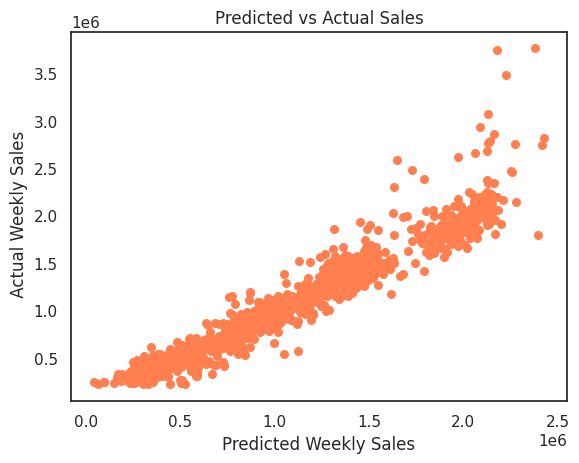

In [530]:
# Modelling with Linear Regression without imputed Markdowns

predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

It is clear from the above results that the graph with imputed Markdown values is much better. 

In [531]:
# Getting the dataset ready for modelling
data=data_imputed.copy()


In [532]:
offset = timedelta(days=90)
split_date=data.Date.max()-offset

In [533]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

In [534]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers


In [535]:
data_train.columns


Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Year_2011', 'Year_2012', 'Week_1.0', 'Week_2.0',
       'Week_3

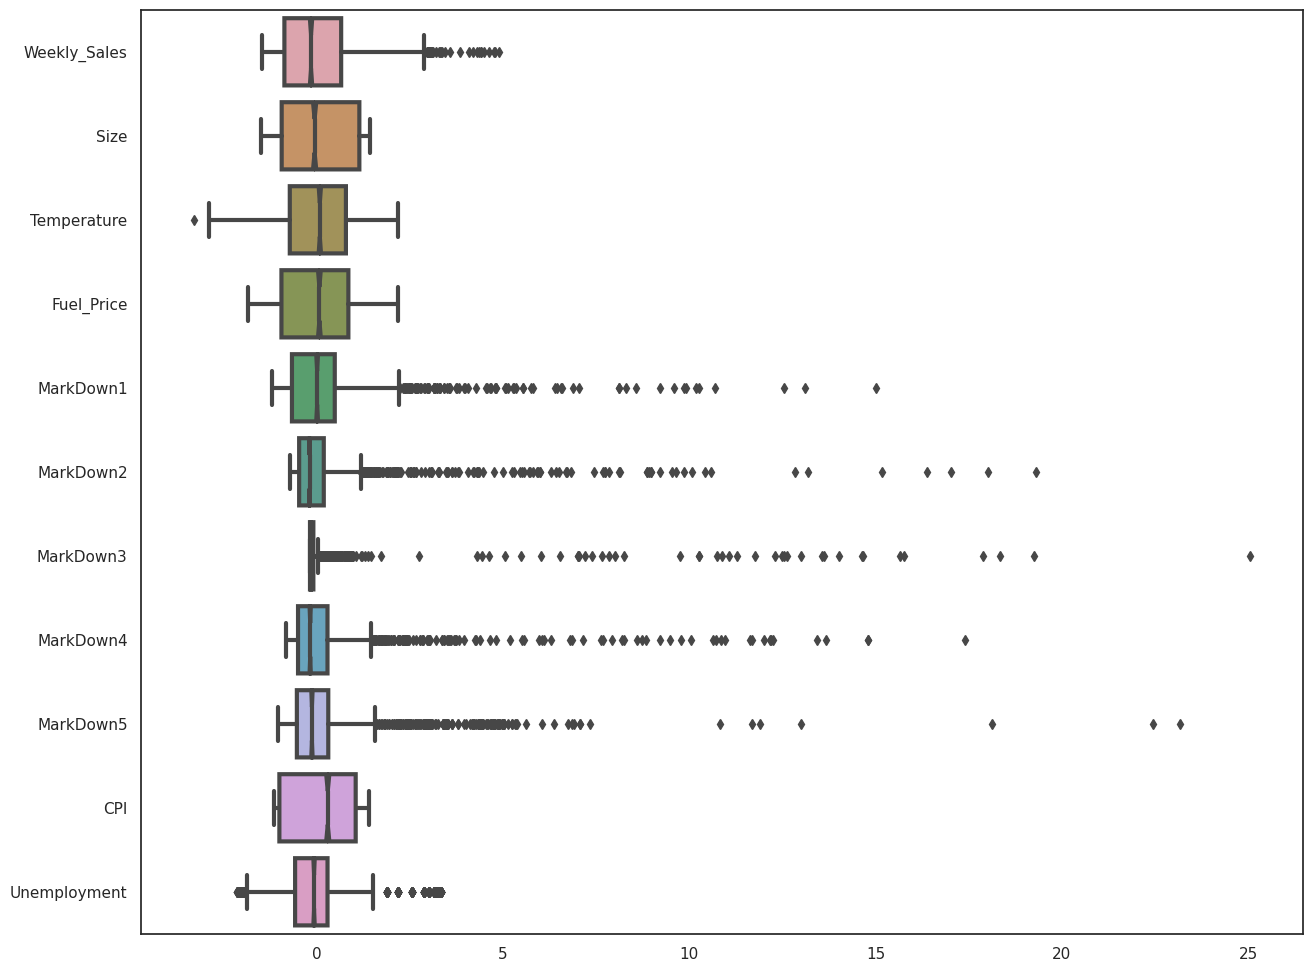

In [536]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

Inferrenc from the graph: There are a lot of outliers present in Markdown columns.Lets deal with the outliers now.

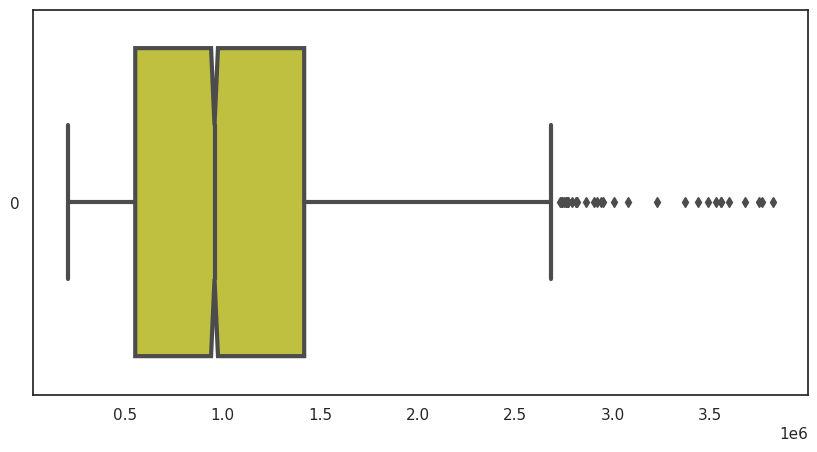

In [537]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [538]:
data_train

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0
1087,2011-09-30,809049.37,155078.0,72.20,3.355,5800.9736,3350.8232,177.4984,1140.7480,5335.5460,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1692,2012-05-18,1020486.05,112238.0,84.51,4.110,20882.5000,3076.4088,3.7300,9506.7500,2091.6700,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2953,2011-11-18,737014.09,140167.0,61.90,3.308,8864.3400,545.1700,58.7100,747.4300,4961.4400,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2973,2012-04-06,761956.58,140167.0,69.02,3.891,14207.8500,2723.8172,6.9900,3662.2600,1615.2700,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3374,2011-09-23,1232376.49,203819.0,60.61,3.899,9192.0980,5100.1328,2826.1436,3034.3272,6308.2604,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,2011-05-06,257031.19,39690.0,77.92,4.193,295.0504,275.9792,93.4268,4391.6092,2289.4368,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3509,2011-07-29,668390.82,128107.0,74.72,3.829,6884.2296,4222.3176,196.8496,2802.9308,3605.7564,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3897,2010-10-15,1158062.99,206302.0,75.00,2.976,8740.2648,3587.5740,192.1348,4045.6512,7224.6136,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4450,2010-06-04,1149234.96,203007.0,66.69,2.700,10138.0036,3681.9284,185.3204,5734.5772,5580.9484,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [539]:
# I fixed $3,000,000 as the upper limit
data_train[data_train.Weekly_Sales>3000000].shape


(14, 76)

In [540]:
# Dropping the outliers because they are only 14

data_train=data_train[data_train['Weekly_Sales']<3000000]

data_train


,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2011,Year_2012,Week_1.0,Week_2.0,Week_3.0,Week_4.0
1087,2011-09-30,809049.37,155078.0,72.20,3.355,5800.9736,3350.8232,177.4984,1140.7480,5335.5460,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1692,2012-05-18,1020486.05,112238.0,84.51,4.110,20882.5000,3076.4088,3.7300,9506.7500,2091.6700,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2953,2011-11-18,737014.09,140167.0,61.90,3.308,8864.3400,545.1700,58.7100,747.4300,4961.4400,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2973,2012-04-06,761956.58,140167.0,69.02,3.891,14207.8500,2723.8172,6.9900,3662.2600,1615.2700,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3374,2011-09-23,1232376.49,203819.0,60.61,3.899,9192.0980,5100.1328,2826.1436,3034.3272,6308.2604,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,2011-05-06,257031.19,39690.0,77.92,4.193,295.0504,275.9792,93.4268,4391.6092,2289.4368,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3509,2011-07-29,668390.82,128107.0,74.72,3.829,6884.2296,4222.3176,196.8496,2802.9308,3605.7564,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3897,2010-10-15,1158062.99,206302.0,75.00,2.976,8740.2648,3587.5740,192.1348,4045.6512,7224.6136,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4450,2010-06-04,1149234.96,203007.0,66.69,2.700,10138.0036,3681.9284,185.3204,5734.5772,5580.9484,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Part 6: Improving and Evaluating model

In [541]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]

In [542]:
# Splitting the dataset so that test data is for last 90 days

X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

In [543]:
y_train.shape

(5836,)

#### LGBM Regressor

<b>LightGBM is a relatively new algorithm. It is a gradient boosting framework that uses tree based learning algorithm.</b>

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.

It chooses the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. Light GBM is prefixed as ‘Light’ because of its high speed.

<b>Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.</b>

In [544]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

In [545]:
lgbm_features = lgb.LGBMRegressor() 


In [546]:
lgbm_features.fit(X_train, y_train)


LGBMRegressor()

In [547]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

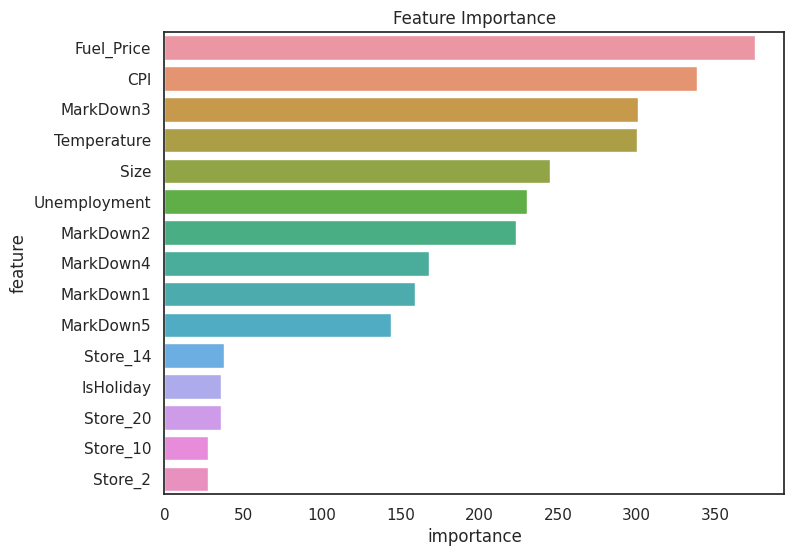

In [548]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');

Inferrence from the graph:

The top 5 features imputed from the graph are Fuel_Price, CPI, Markdown3, Temperature and Size.

### Lasso Feature Selection

<b>LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.</b>

The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.

<b>So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.</b>

In [549]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [550]:
# Creating a dataframe of result values

lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

,feature,coef,abscoef
0,Size,347440.079024,347440.079024
11,Type_A,172384.214686,172384.214686
21,Store_10,131966.691823,131966.691823
19,Store_8,-98376.268236,98376.268236
51,Store_40,-92706.010433,92706.010433
43,Store_32,-89647.947656,89647.947656
44,Store_33,-85179.792633,85179.792633
20,Store_9,-77209.609207,77209.609207
52,Store_41,-77163.472535,77163.472535
45,Store_34,-75254.886146,75254.886146


In [551]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

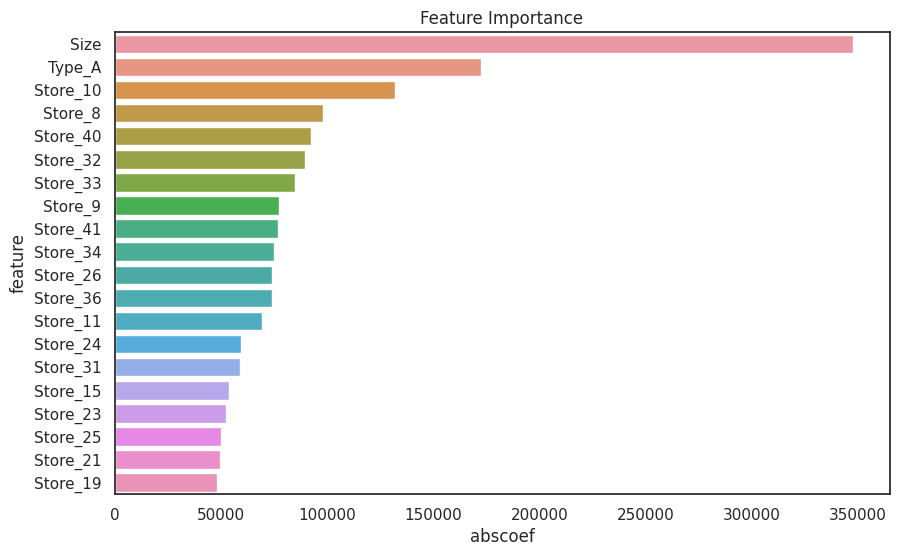

In [552]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lasso_feat.head(20), x='abscoef', y='feature');

Inferrence from the graph:
The graph shows the importance of differrent features from our dataset

In [553]:
# We will set the predictors that we got from Lasso as our actual predictors and use in further models

actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values


In [554]:
# Lets see the best alpha score

lasso_cv.alpha_


453.8419729195475

In [555]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=453.8419729195475)

In [556]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.924779   0.90398037 0.93547664 0.9331181  0.94408466 0.9453963
 0.93769597 0.91546281 0.9465874  0.94677334]
0.9333354604784866


Getting a cross validation score of around 0.93 is good. Now lets use this to predict our last 90 days data

In [557]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9602241138737961
Adjusted R2:  0.9559219781827266


In [558]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()

print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 500899948589.31714
Test Residual 39751906327.904655
Residual ratio of Test to Train 0.07936097106789054


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size.

The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big and in terms of millions

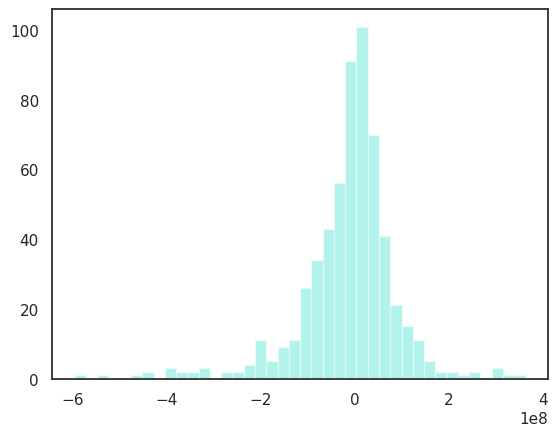

In [559]:
sns.distplot(test_resids, kde=False, bins=40, color = 'turquoise')
plt.show()

Inferrence from the graph: The residuals looks ok and almost like a normal distribution


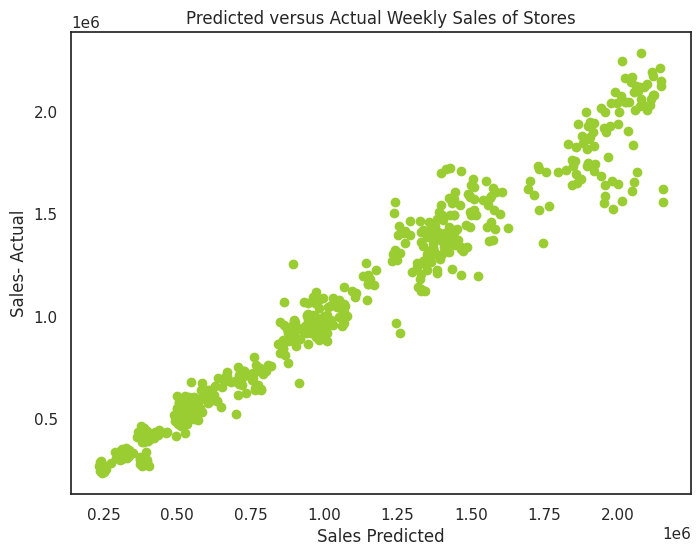

In [560]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
#plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. The actual vs Predicted Sales looks promising

In [561]:
# We will set the predictors to the ones that are selected from Lasso 
# and will use this predictors and Train Test split for further use in all my models.

X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

### Random Forest Regressor

In [562]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')


In [563]:
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.9510568998855709

In [564]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.7950871303240952
Adjusted R2:  0.774634433350794


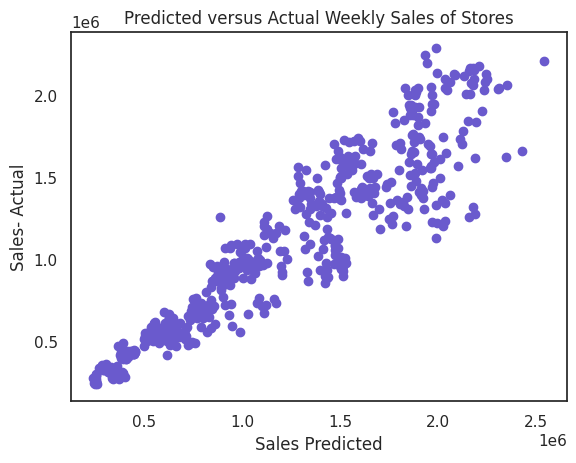

In [565]:
plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [566]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149331744956.5001
Test Residual 91613966353.2
Residual ratio of Test to Train 0.6134929072173293


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.

### Gradient Boosting Regressor

In [567]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)


In [568]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9507840820342331

In [569]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.7716638987680192
Adjusted R2:  0.7488732897938291


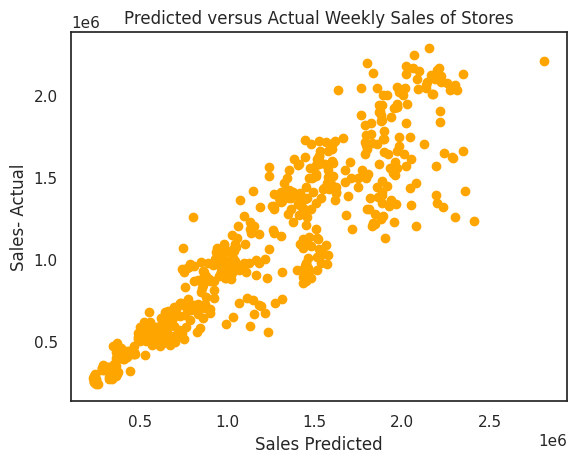

In [570]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [571]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 70612589501.0122
Test Residual 94800872534.607
Residual ratio of Test to Train 1.3425491573743809


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign. I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.



### Support Vector Regression

In [572]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [573]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.7362857416266009

In [574]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.7691410622831322
Adjusted R2:  0.7460986447709024


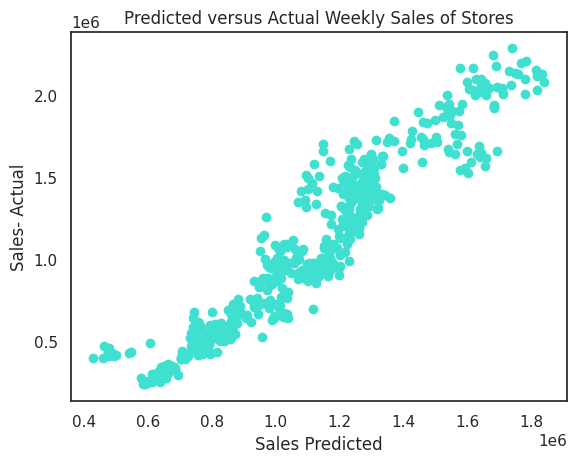

In [575]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [576]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual", np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149331744956.5001
Test Residual 129959583338.61757
Residual ratio of Test to Train 0.8702743236307486


This looks great! The cross validation score and score on test data are almost same even though its not a very high percentage. Even the residuals are small. This tells atleast there is no much overfittig.

<b>So out of all models the best comes with Lasso regression.</b>

In [577]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [578]:
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

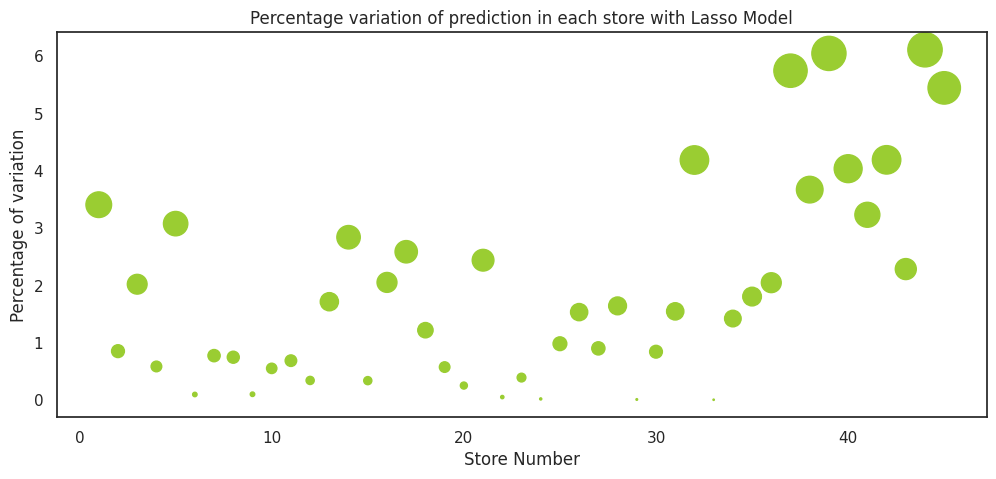

In [579]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
#plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

This plot shows the variation of prediction or the percentage residual change for each store.

We can see that there are around 4 stores which have more than 5% variation in prediction.

The smaller the bubble the better it is since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.

In [580]:
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting','SupportVector')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score,svr_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2,svr_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue,svr_residue)

## Part 7: Insights and Conclusion


1. From the modeling we have found Lasso method works the best by itself with an accuracy of .93.

2. The rain forest regressor and SVR also works good. We have plotted a percentage residual change with bubbles to check how good is the prediction for each store.

3. This could be a good method to look into each store and see which stores are doing good with this model and which are not.

4. Similarly we can find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

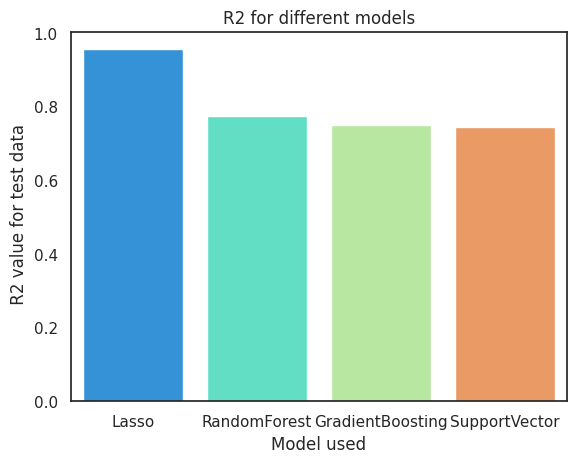

In [581]:
# Checking how the Type of the store have effect on the sales.

sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()

Lasso Regressor gives the best prediction and outperforms all other models as indicated by the R2 values.

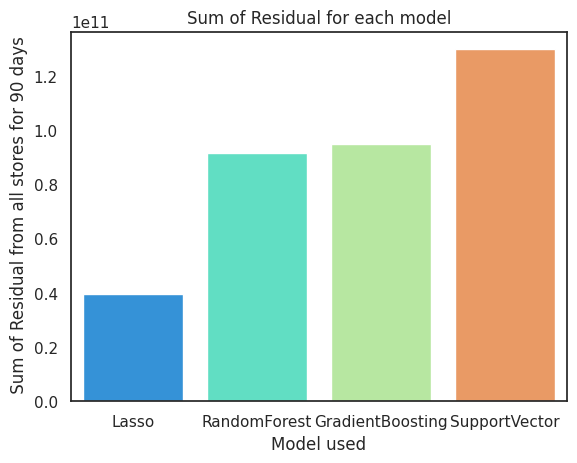

In [582]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual from all stores for 90 days')
plt.title('Sum of Residual for each model')
#plt.savefig('./images/Residual_for_different_models.png')
plt.show()

Even the residual for Lasso model is way smaller compared to other models

<b>Conclusion</b>:

Finally, after building multiple models to predict the weekly sales of 45 stores, we got the best accuracy of around 94% of accuracy for 3 months(90 Days).

Out of all the models, we select the Lasso Regressor as our predictive Model since due to it's highest prediction accuracy with the lowest residual(error)

## Part 8: Benefits 

1. Size of the store is the highest contributing predictor in the model.

2. Each store has a unique prediction power. They can be separately analyzed to get prediction for each individual store.

3. The Sales are very high during November and December and go down in January. It can be because of Christmas when people spend money to buy gifts. So its better to hire more employees more staff as casual employee in November and December and encourage permanent staff to take leaves during January.

4. The predicted sales data can be used to analyse the sales pattern and accordingly adjust the staff in the store.

5. When we implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which will further help in better planning and cost cutting for inventory management, supply chain management and human resource.

6. The low selling stores should look forward to increasing their size and capacity to store more items and consumer products.

7. Special discount coupons can be distributed during low selling periods to attract more customers

8. Sales are likely to fluctuate during holidays. Special offers can be given during festive season accompanied with suitable marketing to keep the sales high during holidays as well.

*************************************************************************************************